In [1]:
import sys
sys.path.append('..')

In [2]:
from siggi import filters, spectra, calcIG
import matplotlib.pyplot as plt
import numpy as np
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
f = filters()
s = spectra()
red_spec = s.get_red_spectrum()
blue_spec = s.get_blue_spectrum()

In [4]:
def prior_flat(vals):
    flat_prob = np.ones(len(vals))
    return flat_prob/np.sum(flat_prob)

In [5]:
x = np.arange(300., 1200., 25.)
y = np.arange(300., 1200., 25.)
print(len(x))
xx, yy = np.meshgrid(x, y)

36


In [6]:
trap_dict = f.trap_filters([[300., 120, 60], [800., 120, 60]])
c = calcIG(trap_dict, [red_spec, blue_spec],
                   prior_flat, 0., 1., 1., snr=5.)
c.calc_IG()

0.9720404734422043

In [7]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, [red_spec, blue_spec],
                   prior_flat, 0., 1., 1., snr=5.)
        zz[x1, y1] = c.calc_IG()
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35


In [8]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,'Information Gain Example 1')

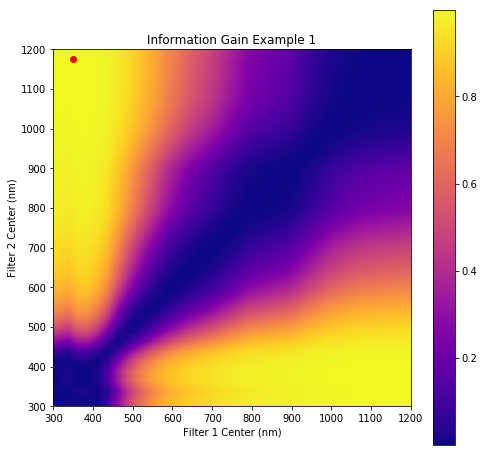

In [9]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1200., 300., 1200.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 1')

In [10]:
x[x_max], y[y_max], zz[x_max, y_max]

(350.0, 1175.0, 0.9971175166963132)

Text(0.5,1,'Example 1 Filters and Spectra')

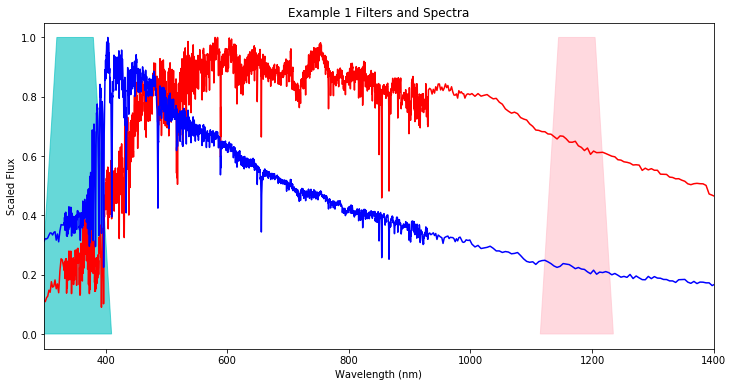

In [11]:
fig = plt.figure(figsize=(12,6))
plt.plot(red_spec.wavelen, red_spec.flambda/np.max(red_spec.flambda), c='r')
plt.plot(blue_spec.wavelen, blue_spec.flambda/np.max(blue_spec.flambda), c='b')
plt.fill([x[x_max]-60, x[x_max]-30, x[x_max]+30, x[x_max]+60], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([y[y_max]-60, y[y_max]-30, y[y_max]+30, y[y_max]+60], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(299., 1400.)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 1 Filters and Spectra')

### Example 2

In [12]:
s = spectra()

In [13]:
sig_spec = s.get_sigmoid_spectrum()

(200.0, 600.0)

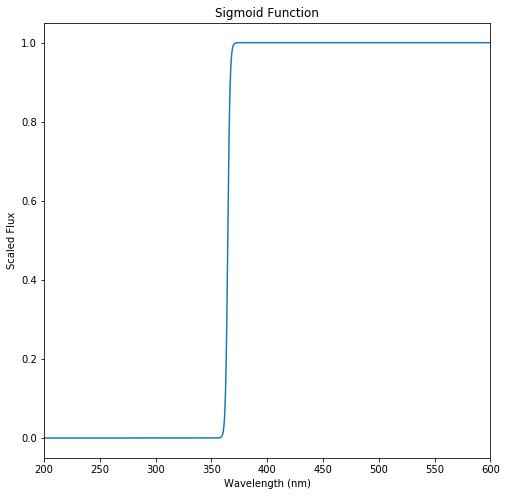

In [14]:
fig = plt.figure(figsize=(8,8))
plt.plot(sig_spec.wavelen, sig_spec.flambda)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Sigmoid Function')
plt.xlim(200., 600.)

In [15]:
y2_min = 0.
y2_max = 2.5
y2_step = 0.05

In [16]:
def prior_z(z, z0=0.5):
    return (z**2.)*np.exp(-(z/z0)**1.5)/np.sum((z**2.)*np.exp(-(z/z0)**1.5))

Text(0.5,1,'Redshift Prior')

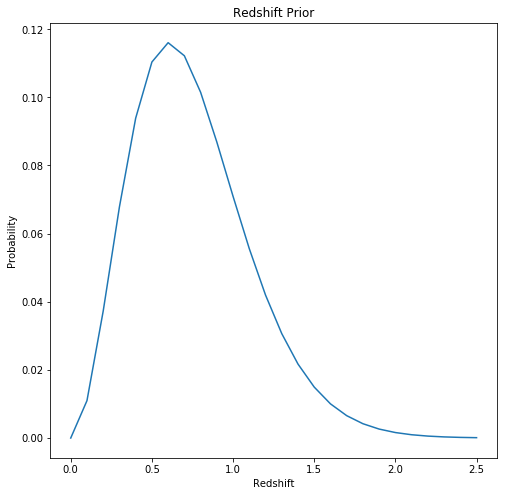

In [17]:
fig = plt.figure(figsize=(8,8))
plt.plot(np.arange(0.0, 2.56, 0.1), prior_z(np.arange(0.0, 2.56, 0.1)))
plt.xlabel('Redshift')
plt.ylabel('Probability')
plt.title('Redshift Prior')

In [18]:
from copy import deepcopy
z_shift_seds = []
for z_val in np.arange(0.00, 2.52, .05):
    spec_copy = deepcopy(sig_spec)
    spec_copy.redshiftSED(z_val)
    z_shift_seds.append(spec_copy)

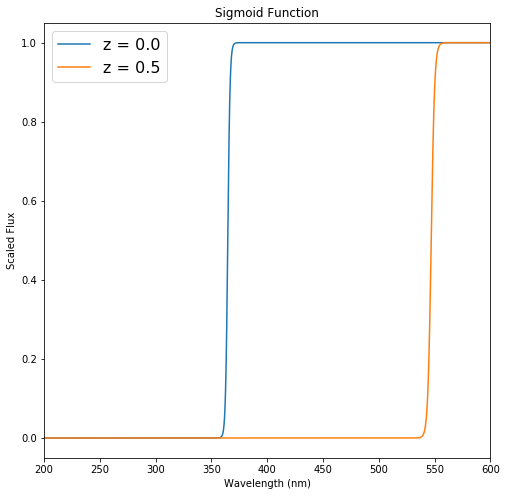

In [19]:
fig = plt.figure(figsize=(8,8))
plt.plot(sig_spec.wavelen, sig_spec.flambda, label='z = 0.0')
plt.plot(z_shift_seds[10].wavelen, z_shift_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Sigmoid Function')
plt.xlim(200., 600.)
plt.legend(fontsize=16)

In [20]:
trap_dict = f.trap_filters([[850., 80, 40], [1150., 80, 40]])
c = calcIG(trap_dict, z_shift_seds, prior_z, y2_min, y2_max, y2_step)

In [21]:
c.calc_IG()

../siggi/calcIG.py:112: RuntimeWarning: divide by zero encountered in log2
  x_total[idx]))
../siggi/calcIG.py:112: RuntimeWarning: invalid value encountered in multiply
  x_total[idx]))


0.6204856193132446

In [22]:
x = np.arange(300., 1201., 25.)
y = np.arange(300., 1201., 25.)
print(len(x))
xx, yy = np.meshgrid(x, y)

37


In [23]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, z_shift_seds, prior_z, y2_min, y2_max, y2_step)
        zz[x1, y1] = c.calc_IG()
        

0


../siggi/calcIG.py:112: RuntimeWarning: divide by zero encountered in log2
  x_total[idx]))
../siggi/calcIG.py:112: RuntimeWarning: invalid value encountered in multiply
  x_total[idx]))
../siggi/calcIG.py:112: RuntimeWarning: invalid value encountered in true_divide
  x_total[idx]))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [24]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,'Information Gain Example 2')

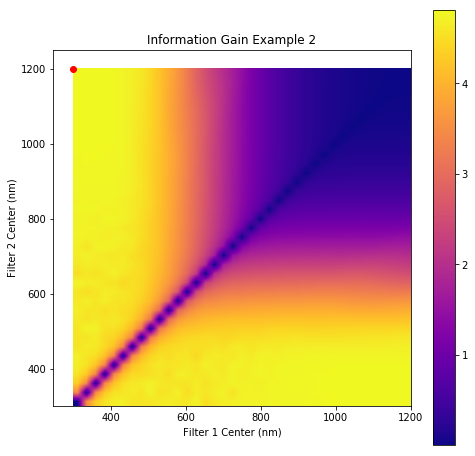

In [25]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1200., 300., 1200.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 2')

In [26]:
x[x_max], y[y_max], zz[x_max, y_max]

(300.0, 1200.0, 4.807266795906156)

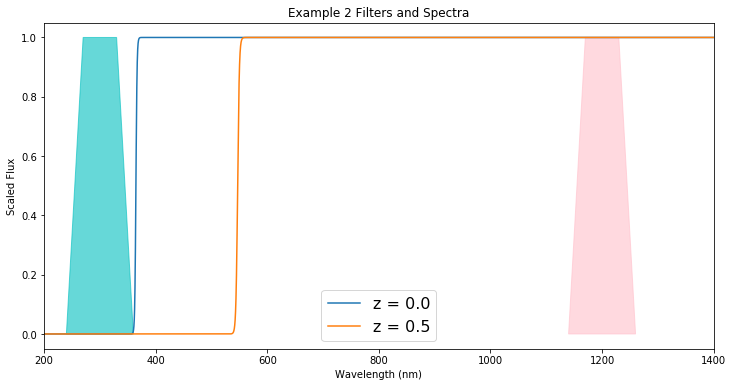

In [27]:
fig = plt.figure(figsize=(12,6))
plt.plot(sig_spec.wavelen, sig_spec.flambda, label='z = 0.0')
plt.plot(z_shift_seds[10].wavelen, z_shift_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 2 Filters and Spectra')
plt.fill([x[x_max]-60, x[x_max]-30, x[x_max]+30, x[x_max]+60], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([y[y_max]-60, y[y_max]-30, y[y_max]+30, y[y_max]+60], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(200., 1400.)
plt.legend(fontsize=16)

### Example 3

In [28]:
from copy import deepcopy
z_shift_red_seds = []
for z_val in np.arange(0., 2.51, .05):
    spec_copy = deepcopy(red_spec)
    spec_copy.redshiftSED(z_val)
    z_shift_red_seds.append(spec_copy)

In [29]:
x = np.arange(300., 1201., 25.)
y = np.arange(300., 1201., 25.)
print(len(x))
xx, yy = np.meshgrid(x, y)

37


In [30]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, z_shift_red_seds, prior_z, y2_min, y2_max, y2_step)
        zz[x1, y1] = c.calc_IG()
        

0


../siggi/calcIG.py:112: RuntimeWarning: divide by zero encountered in log2
  x_total[idx]))
../siggi/calcIG.py:112: RuntimeWarning: invalid value encountered in multiply
  x_total[idx]))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [31]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,'Information Gain Example 3')

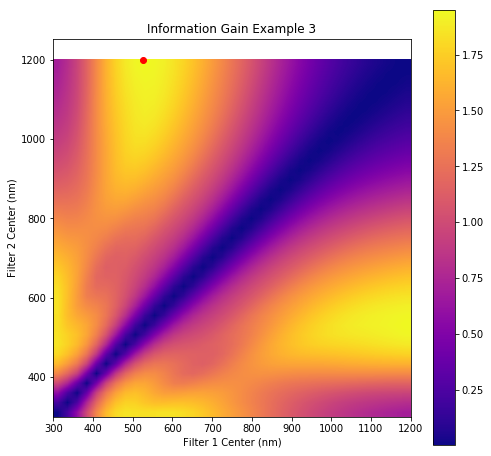

In [32]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1200., 300., 1200.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 3')

In [33]:
x[x_max], y[y_max], zz[x_max, y_max]

(525.0, 1200.0, 1.9477453280598893)

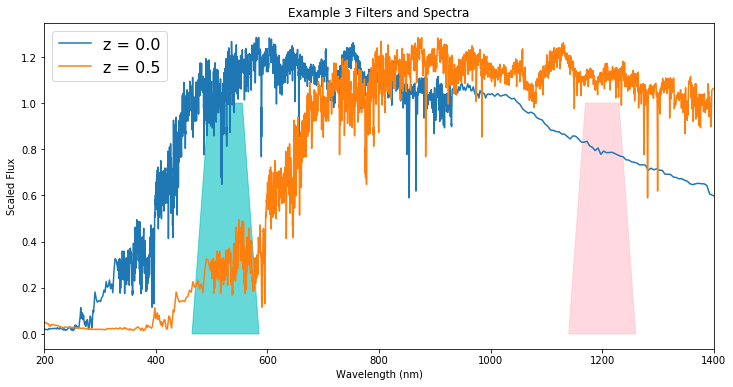

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(red_spec.wavelen, red_spec.flambda, label='z = 0.0')
plt.plot(z_shift_red_seds[10].wavelen, z_shift_red_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 3 Filters and Spectra')
plt.fill([x[x_max]-60, x[x_max]-30, x[x_max]+30, x[x_max]+60], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([y[y_max]-60, y[y_max]-30, y[y_max]+30, y[y_max]+60], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(200., 1400.)
plt.legend(fontsize=16)

### Example 3.1

In [35]:
from copy import deepcopy
z_shift_blue_seds = []
for z_val in np.arange(0., 2.51, .05):
    spec_copy = deepcopy(blue_spec)
    spec_copy.redshiftSED(z_val)
    z_shift_blue_seds.append(spec_copy)

In [36]:
x = np.arange(300., 1201., 25.)
y = np.arange(300., 1201., 25.)
print(len(x))
xx, yy = np.meshgrid(x, y)

37


In [37]:
zz = np.zeros(np.shape(xx))
for x1 in range(len(x)):
    print(x1)
    for y1 in range(len(y)):
        trap_dict = f.trap_filters([[x[x1], 120, 60], [y[y1], 120, 60]])
        c = calcIG(trap_dict, z_shift_blue_seds, prior_z, y2_min, y2_max, y2_step)
        zz[x1, y1] = c.calc_IG()
        

0


../siggi/calcIG.py:112: RuntimeWarning: divide by zero encountered in log2
  x_total[idx]))
../siggi/calcIG.py:112: RuntimeWarning: invalid value encountered in multiply
  x_total[idx]))


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36


In [38]:
x_max, y_max = np.unravel_index(np.argmax(zz), (len(x), len(y)))

Text(0.5,1,'Information Gain Example 3.1')

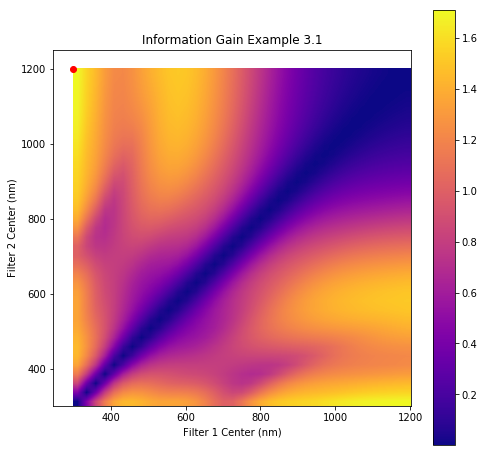

In [39]:
fig = plt.figure(figsize=(8,8))
plt.imshow(zz, origin='lower', interpolation='bilinear', 
           extent=[300., 1201., 300., 1201.], cmap=plt.cm.plasma)
plt.colorbar()
plt.scatter(x[x_max], y[y_max], c='r')
plt.xlabel('Filter 1 Center (nm)')
plt.ylabel('Filter 2 Center (nm)')
plt.title('Information Gain Example 3.1')

In [40]:
x[x_max], y[y_max], zz[x_max, y_max]

(300.0, 1200.0, 1.7068566228315833)

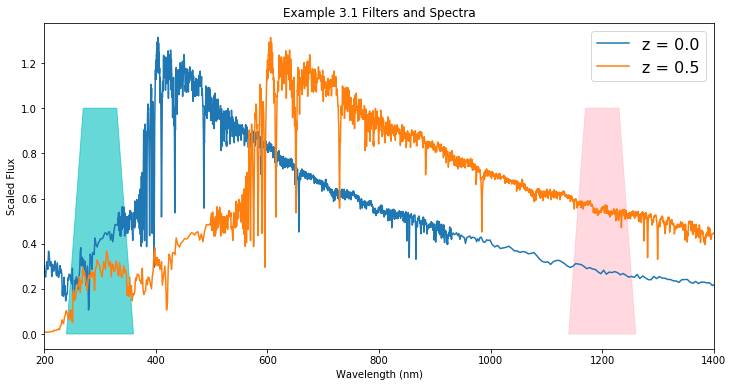

In [41]:
plt.figure(figsize=(12, 6))
plt.plot(blue_spec.wavelen, blue_spec.flambda, label='z = 0.0')
plt.plot(z_shift_blue_seds[10].wavelen, z_shift_blue_seds[10].flambda, label='z = 0.5')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Scaled Flux')
plt.title('Example 3.1 Filters and Spectra')
plt.fill([x[x_max]-60, x[x_max]-30, x[x_max]+30, x[x_max]+60], [0, 1, 1, 0], c='c', alpha=0.6)
plt.fill([y[y_max]-60, y[y_max]-30, y[y_max]+30, y[y_max]+60], [0, 1, 1, 0], c='pink', alpha=0.6)
plt.xlim(200., 1400.)
plt.legend(fontsize=16)